In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
from scipy import ndimage, misc
import math
%matplotlib inline
import cv2
import time
import glob

img_list = []
filenamelist= []
for img in glob.glob("Stop1_1000/*.jpg"):
    #img_list.append(cv2.imread(img,0))
    filenamelist.append(img)
np.array(filenamelist).shape
filenamelist = ['Stop1_1000/10.jpg']

In [6]:
def FindContour_and_outer_defect(gray, contours_final):
    ret, thresh1 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    _ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    hull = cv2.convexHull(contours_final[0])
    #=====
    convex_img = gray.copy()
    cv2.drawContours(convex_img, [hull],-1,(0,0,0),-1)
    convex_img = np.invert(convex_img)
    #=====
    contour_img = gray.copy()
    cv2.drawContours(contour_img, [contours_final[0]],-1,(0,0,0),-1)
    print(contours_final[0].shape)
    contour_img = np.invert(contour_img)
    #=====
    diff_img = convex_img - contour_img
    #=====
    #kernel = np.ones((3,3),np.uint8)
    kernel = np.ones((3,2),np.uint8)
    opening = cv2.morphologyEx(diff_img, cv2.MORPH_OPEN, kernel)
    #=====
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)
    
    return stats

In [7]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center < (radius+10)
    return mask

In [8]:
def mask_innercicle(img):
    
    ret, thresh1 = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
    _ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    import circle_fit as cf

    circle_point = []
    contours_final = []
    for i in range(np.array(contours).shape[0]):
            if(np.array(contours[i]).shape[0]>1500 and cv2.contourArea(contours[i])<5000000):
                contours_final.append(contours[i])
                #print(np.array(contours[i]).shape)

                cor = np.array(contours[i])
                cor = cor.reshape(cor.shape[0],cor.shape[2])
                #print(cor.shape)

                xc,yc,r,_ = cf.least_squares_circle(cor)
                print(xc,yc,r)
                circle_point.append([xc,yc,r])

    cor = np.array(contours[1])
    cor = cor.reshape(cor.shape[0],cor.shape[2])

    xc,yc,r,_ = cf.least_squares_circle(cor)

    h = img.shape[0]
    w = img.shape[1]
    center = (circle_point[1][0].astype(int), circle_point[1][1].astype(int))
    radius = circle_point[1][2].astype(int)
    mask = create_circular_mask(h, w, center=center, radius=radius)
    
    mask_array = np.ma.masked_array(img, mask=mask,fill_value = 255)
    img_temp = mask_array.filled()
    return img_temp, contours_final

Stop1_1000/10.jpg
1105.162124940649 1097.0700256057187 758.1608258472824
1102.6384358810446 1095.8735624614744 641.2404835000697
(2303, 1, 2)
1.6186680793762207
.\Detect\10_Detect.jpg


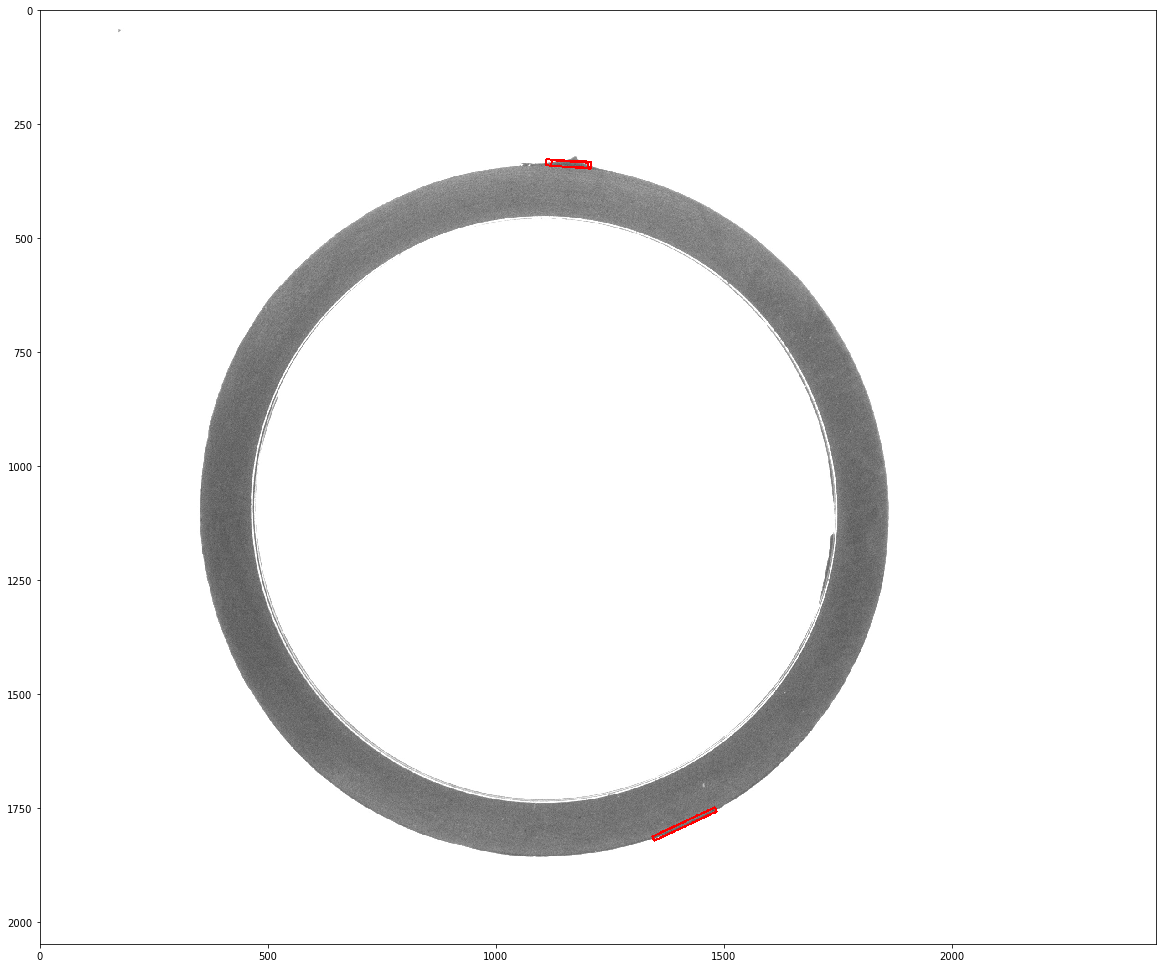

In [27]:
for iter_file in range(len(filenamelist)):
    start = time.time()
    filename = filenamelist[iter_file]
    print(filename)
    img = np.array(cv2.imread(filename,0))
    
    vis_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)   
    img,contours_final = mask_innercicle(img)
    
    #img_temp = cv2.blur(img_temp,(3,3))
    
    #img_temp = ndimage.minimum_filter(img_temp, size=3)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
    #img_temp = clahe.apply(img_temp)
    #img_temp = cv2.blur(img_temp,(3,3))

    vis = img.copy()
     
    
    #=====Find Defect outer
    stats = FindContour_and_outer_defect(img,contours_final)
    #vis = cv2.blur(vis,(5,5))
    # local MSER
    
    area_threshold_1 = 120
    area_threshold_2 = 800
    
    for i in range(2):
            
        if i==0 :
            #mser = cv2.MSER_create(_delta=5, _min_area=area_threshold_2,_max_variation=0.7)
            #mser = cv2.MSER_create(_delta=6, _min_area=area_threshold_2,_max_variation=1.0)
            mser = cv2.MSER_create(_delta=5, _min_area=area_threshold_2,_max_variation=1.5)
            
        else:
            #mser = cv2.MSER_create(_delta=5, _min_area=area_threshold_1, _max_area = area_threshold_2, _max_variation=1.2)
            mser = cv2.MSER_create(_delta=6, _min_area=area_threshold_1, _max_area = area_threshold_2, _max_variation=1.6)
            
        #mser = cv2.MSER_create(_delta=4, _min_area=150,_max_variation=0.5)
        #mser = cv2.MSER_create(_delta=3, _min_area=150,_max_variation=0.25)
        #cv2.MSER_create(_delta=3, _min_area=100,_max_variation=0.3)
        
        regions = mser.detectRegions(vis)
        

        hulls_draw = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions[0]]
        hulls = [cv2.approxPolyDP(p.reshape(-1, 1, 2), 0.5, True) for p in regions[0]]
        #print(hulls)
        #print(np.array(hulls).shape)
        
        #print(np.array(hulls).shape[0])
        #==============每個小區域去看內部的min和mean，因為有的是太白，並非太黑
        
        for j in range(np.array(hulls).shape[0]):
            
            if(i==1):
                mask = np.zeros_like(vis)
                mask_now = cv2.fillPoly(mask, [hulls[j]],1)
                mask_1 = vis*mask_now
                min_in_poly = np.min(mask_1[mask_1>0])
                mean_in_poly =np.mean(mask_1[(mask_1>0)])
                
                
                rect = cv2.minAreaRect(hulls[j])
                
                #plt.figure(figsize=(20,20))
                #plt.imshow(mask_1,cmap = 'gray')
                #region around the defect area
                mean_in_poly2 = [255 for n in range(4)]
                M = [np.float32([[1, 0, 15], [0, 1, -15]]),np.float32([[1, 0, 15], [0, 1, 15]]),np.float32([[1, 0, -15], [0, 1, -15]]),np.float32([[1, 0, -15], [0, 1, 15]])]                

                (rows, cols) = mask_now.shape[:2]
                for M_iter in range(len(M)):
                    mask_2 = cv2.warpAffine(mask_now, M[M_iter], (cols, rows)) 
                    mask_2 = vis*mask_2
                    mean_now = np.mean(mask_2[(mask_2>0)&(mask_2<230)])
                    if(not (math.isnan(mean_now))):
                        mean_in_poly2[M_iter] = mean_now
                
                #print(mean_in_poly, " ", mean_in_poly2)
                flag = sum(mean_in_poly>mean_in_poly2)
                
                # 可以用更好的方法處理邊界問題
                if(flag>2 or mean_in_poly > 130 or min_in_poly>100):
                #if((np.count_nonzero((mask_1<mean) & (mask_1>0))/np.count_nonzero(mask_1>0))<0.5):
                #if(min_in_poly>100 or mean_in_poly>130):
                    continue
                    
            # refer https://blog.csdn.net/lanyuelvyun/article/details/76614872
            if(i==1):
                box = cv2.boxPoints(rect) 
                box = np.int0(box)
                cv2.drawContours(vis_rgb, [box], 0, (255, 0, 0), 3)

            #cv2.polylines(vis_rgb, [hulls_draw[j]], 1, (0, 0, 255),2)
            
            
        #=====================================================================
    #===================Draw outer defect=============================
    
#     for j in range(len(stats)):
#         area = stats[j][4]
#         if(area < 20000):
#             cv2.rectangle(vis_rgb, (stats[j][0], stats[j][1]), 
#                           (stats[j][0]+stats[j][2], stats[j][1]+stats[j][3]), (0, 255,0),2)

    #=================================================================
    end = time.time()
    print(end - start)
    print(".\\Detect\\" +filenamelist[iter_file][11:-4]+'_Detect.jpg')
    plt.figure(figsize=(20,20))
    plt.imshow(vis_rgb)
    cv2.imwrite(".\\Detect\\" +filenamelist[iter_file][11:-4]+'_Detect.jpg',vis_rgb)
#   plt.close()